# 1.Imports

In [25]:
import re
import sys
import yaml
import torch
import random
import librosa
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from scipy.io import wavfile
import matplotlib.pyplot as plt

sys.path.append("../")
from kaituoxu.conv_tasnet import ConvTasNet
from asteroid.data import MUSDB18Dataset

In [26]:
DATA_DIR = Path("../musdb_data")

TEST_SONG = DATA_DIR/"test/Al James - Schoolboy Facination.stem.mp4"

TRAINING_DIR = Path('../experiment_results/exp-13/training_20220313-122104.468')
cfg_path = next(TRAINING_DIR.glob('*.yaml'))
history_path = TRAINING_DIR/"history.csv"
best_model_path = TRAINING_DIR/"model.pth"

try:
    last_model_path = sorted(list(TRAINING_DIR.glob("model_epoch*")), key=lambda x: int("".join(re.findall(r"\d", str(x)))))[-1]
except:
    last_model_path = None

with open(str(cfg_path), 'r') as file:
    CFG = yaml.load(file, Loader=yaml.FullLoader)

assert cfg_path.exists() and history_path.exists() and best_model_path.exists() and cfg_path.exists()

## Hyper parameters:

In [27]:
for key, value in CFG.items():
    print(f">>> {key.upper()} -> {value}")

>>> SAMPLE_RATE -> 22050
>>> SIZE -> -1
>>> LEARNING_RATE -> 0.001
>>> N_EPOCHS -> 100
>>> TRAIN_BATCH_SIZE -> 2
>>> TEST_BATCH_SIZE -> 2
>>> SEGMENT_SIZE -> 4
>>> RANDOM_TRACK_MIX -> False
>>> TARGETS -> ['drums', 'bass', 'other', 'vocals']
>>> X -> 10
>>> R -> 4
>>> B -> 256
>>> H -> 512
>>> SC -> 256
>>> P -> 3
>>> L -> 20
>>> N -> 512
>>> STRIDE -> 10
>>> LOSS -> l1_loss
>>> STORE_GRADIENT_NORM -> True
>>> VERBOSE -> 0
>>> GRADIENT_CLIPPING -> 5
>>> SAVE_WEIGHTS_EACH_EPOCH -> False
>>> NUM_WORKERS -> 2
>>> DEVICE -> cpu


# 2. Learning Curves

In [28]:
df = pd.read_csv(history_path)
epochs = df.index.values
train_loss = df.train_loss
val_loss = df.val_loss

In [29]:
df

,epoch,train_loss,val_loss,train_mse_loss,val_mse_loss,train_snr,val_snr,lr
0,0,0.023681,0.023926,0.001197,0.001189,-14.707563,-19.699129,1.000000e-03
1,1,0.022703,0.030356,0.001197,0.001189,-14.319911,-18.147832,1.000000e-03
2,2,0.029403,0.019901,0.001197,0.001189,-14.180089,-17.422884,1.000000e-03
3,3,0.019931,0.022305,0.001197,0.001189,-13.149370,-16.345361,1.000000e-03
4,4,0.024016,0.016930,0.001197,0.001189,-13.655058,-14.679458,1.000000e-03
...,...,...,...,...,...,...,...,...
96,96,0.016430,0.015099,0.001197,0.001189,-10.737120,-9.650688,2.441406e-07
97,97,0.017671,0.015417,0.001197,0.001189,-9.620216,-12.284346,2.441406e-07
98,98,0.017169,0.015621,0.001197,0.001189,-9.165894,-12.583341,2.441406e-07
99,99,0.017307,0.016104,0.001197,0.001189,-9.443329,-9.799011,2.441406e-07


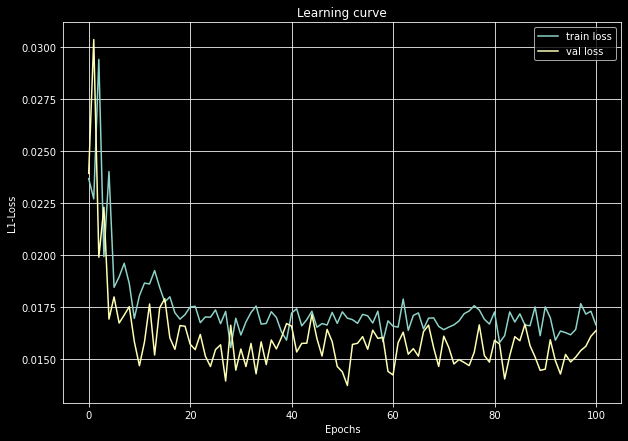

In [30]:
plt.figure(figsize=(10, 7))
plt.plot(epochs, train_loss, label='train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.title("Learning curve")
plt.xlabel("Epochs")
plt.ylabel("L1-Loss")
plt.legend()
plt.grid()
plt.plot();

## Observations :



# 3. Load model

In [31]:
TARGETS = CFG["targets"]
N_SRC = len(TARGETS)
SAMPLE_RATE = CFG["sample_rate"]
SIZE = None if CFG["size"] == -1 else CFG["size"]
LR = CFG["learning_rate"]
N_EPOCHS = CFG["n_epochs"]
TRAIN_BATCH_SIZE = CFG["train_batch_size"]
TEST_BATCH_SIZE = CFG["test_batch_size"]
NUM_WORKERS = CFG["num_workers"]
if "device" in CFG:
    if CFG["device"] == "cuda" and torch.cuda.is_available():
        DEVICE = torch.device("cuda")
    else:
        DEVICE = torch.device("cpu")
else:
    DEVICE = "cpu"

X = CFG["X"]
R = CFG["R"]
B = CFG["B"]
H = CFG["H"]
Sc = CFG["Sc"]
P = CFG["P"]
L = CFG["L"]
N = CFG["N"]
STRIDE = CFG["stride"]
CLIP = CFG["gradient_clipping"]

model = ConvTasNet(
    C=N_SRC,
    X=X,
    R=R,
    B=B,
    H=H,
    P=P,
    L=L,
    N=N,
    stride=STRIDE,
    mask_nonlinear="softmax",
    device=DEVICE
).to(DEVICE)

model.load_state_dict(torch.load(best_model_path)["model_state_dict"])

<All keys matched successfully>

In [32]:
TARGETS

['drums', 'bass', 'other', 'vocals']

# 4. Separation test

In [33]:
sound, sr = librosa.load(TEST_SONG.__str__(), sr=SAMPLE_RATE)

/Users/alexandre/opt/anaconda3/envs/IA321_env/lib/python3.9/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [34]:
start = random.randint(0, len(sound) - 10 * SAMPLE_RATE)
stop = start + 10 * SAMPLE_RATE

sound = torch.tensor(sound[start:stop])

In [35]:
pred = model(sound.view(1, -1))

/Users/alexandre/Cours/3A/Cours/IA321 - Blind Source Separation/Blind Source Separation/Music-Source-Separation/notebooks/../kaituoxu/utils.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  frame = signal.new_tensor(frame).long()  # signal may in GPU or CPU


In [36]:
pred.shape

torch.Size([1, 4, 220500])

In [37]:
TARGETS

['drums', 'bass', 'other', 'vocals']

In [38]:
wavfile.write(f"./mix.wav", SAMPLE_RATE, sound.view(-1).detach().numpy())
for i, name in enumerate(TARGETS):
    wavfile.write(f"./{name}.wav", SAMPLE_RATE, pred[0][i].detach().numpy())